Epoch 1/60
1309/1309 ━━━━━━━━━━━━━━━━━━━━ 2s 668us/step - accuracy: 0.7121 - loss: 0.7365 - val_accuracy: 0.7936 - val_loss: 0.4460
Epoch 2/60
1309/1309 ━━━━━━━━━━━━━━━━━━━━ 1s 568us/step - accuracy: 0.8072 - loss: 0.5713 - val_accuracy: 0.8315 - val_loss: 0.4034
Epoch 3/60
1309/1309 ━━━━━━━━━━━━━━━━━━━━ 1s 547us/step - accuracy: 0.8251 - loss: 0.5344 - val_accuracy: 0.8422 - val_loss: 0.3872
Epoch 4/60
1309/1309 ━━━━━━━━━━━━━━━━━━━━ 1s 551us/step - accuracy: 0.8286 - loss: 0.5214 - val_accuracy: 0.8387 - val_loss: 0.3813
Epoch 5/60
1309/1309 ━━━━━━━━━━━━━━━━━━━━ 1s 555us/step - accuracy: 0.8361 - loss: 0.5047 - val_accuracy: 0.8323 - val_loss: 0.3943
Epoch 6/60
1309/1309 ━━━━━━━━━━━━━━━━━━━━ 1s 563us/step - accuracy: 0.8405 - loss: 0.4955 - val_accuracy: 0.8281 - val_loss: 0.3963
Epoch 7/60
1309/1309 ━━━━━━━━━━━━━━━━━━━━ 1s 565us/step - accuracy: 0.8425 - loss: 0.4844 - val_accuracy: 0.8643 - val_loss: 0.3365
Epoch 8/60
1309/1309 ━━━━━━━━━━━━━━━━━━━━ 1s 620us/step - accuracy: 0.8464 -

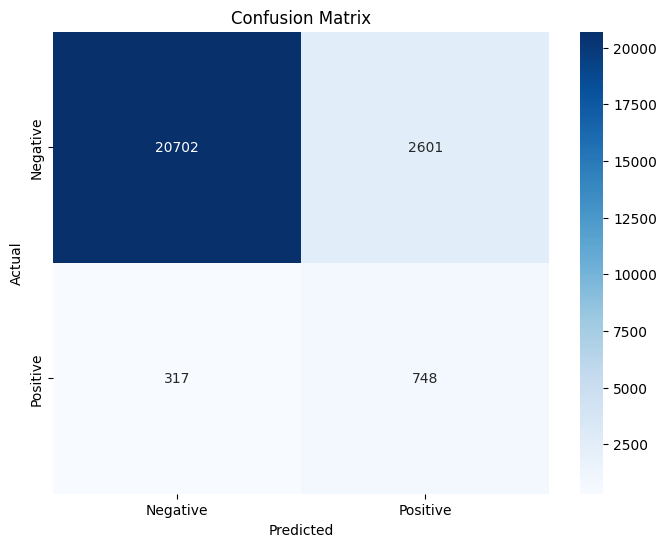

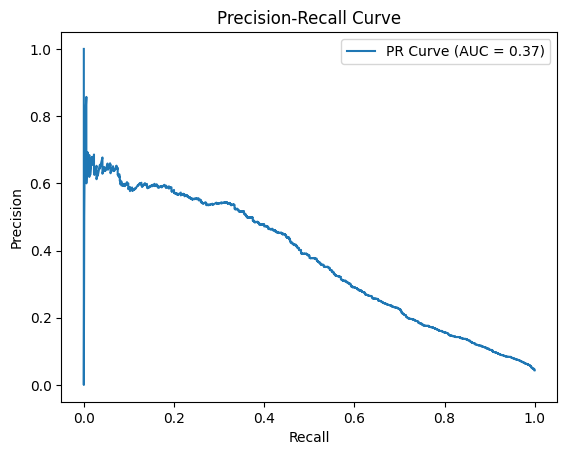

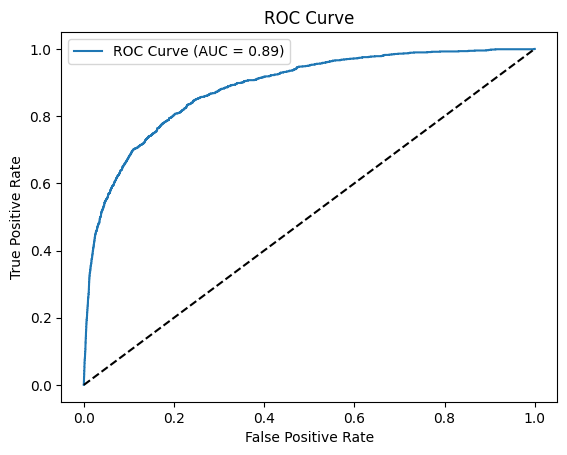

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, Flatten, Input, Concatenate, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from sklearn.metrics import confusion_matrix, precision_score, recall_score, classification_report, roc_curve, roc_auc_score, precision_recall_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt

# Load and prepare data
df = pd.read_csv("/Users/adrealow/Documents/Github/dsa4262-sequenceseekers/data/parsed_data_final.csv")  # Adjust the file path if necessary

# Define categorical features and other features
categorical_features = []  # Update if you have any categorical features
additional_cols = ['Transcript ID', 'Position']
feature_cols = [
    'N1 Length Avg', 'N1 Length Median', 'N1 Length Min', 'N1 Length Max',
    'N1 SD Avg', 'N1 SD Median', 'N1 SD Min', 'N1 SD Max',
    'N1 Mean Avg', 'N1 Mean Median', 'N1 Mean Min', 'N1 Mean Max',
    'N2 Length Avg', 'N2 Length Median', 'N2 Length Min', 'N2 Length Max',
    'N2 SD Avg', 'N2 SD Median', 'N2 SD Min', 'N2 SD Max',
    'N2 Mean Avg', 'N2 Mean Median', 'N2 Mean Min', 'N2 Mean Max',
    'N3 Length Avg', 'N3 Length Median', 'N3 Length Min', 'N3 Length Max',
    'N3 SD Avg', 'N3 SD Median', 'N3 SD Min', 'N3 SD Max',
    'N3 Mean Avg', 'N3 Mean Median', 'N3 Mean Min', 'N3 Mean Max'
]

# Split data into features and target
X = df[additional_cols + feature_cols]
y = df['Label']  # Assuming 'Label' is your target variable

# Step 2: Train-test split without stratification
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocess the numerical features
scaler = StandardScaler()
train_X_num = scaler.fit_transform(train_X[feature_cols])
test_X_num = scaler.transform(test_X[feature_cols])

# Over- and under-sampling with SMOTE
over = SMOTE(sampling_strategy=0.3, random_state=42)  # Adjust the sampling strategy as needed
under = RandomUnderSampler(sampling_strategy=0.5, random_state=42)  # Adjust the sampling strategy as needed
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

train_X_resampled, train_y_resampled = pipeline.fit_resample(train_X_num, train_y)

# Create a neural network model
input_num = Input(shape=(train_X_resampled.shape[1],))

x = Dense(64, activation='relu')(input_num)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Dense(32, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Dense(16, activation='relu')(x)
x = BatchNormalization()(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=input_num, outputs=output)

# Compile the model with modified class weights
class_weights = {0: 1, 1: 2}  # Adjust the weights to balance precision and recall
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(train_X_resampled, train_y_resampled, epochs=60, batch_size=64, validation_data=(test_X_num, test_y), class_weight=class_weights)

# Evaluate the model
loss, accuracy = model.evaluate(test_X_num, test_y)
print(f'Test Accuracy: {accuracy:.2f}')

# Predict on the test set
y_pred_prob = model.predict(test_X_num)
y_pred = (y_pred_prob > 0.5).astype("int32")

# Confusion matrix
cm = confusion_matrix(test_y, y_pred)
print("Confusion Matrix:")
print(cm)

# Precision and Recall
precision = precision_score(test_y, y_pred)
recall = recall_score(test_y, y_pred)
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')

# Classification report
print("Classification Report:")
print(classification_report(test_y, y_pred))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Plot Precision-Recall curve
precision_vals, recall_vals, _ = precision_recall_curve(test_y, y_pred_prob)
pr_auc = auc(recall_vals, precision_vals)
plt.figure()
plt.plot(recall_vals, precision_vals, label=f'PR Curve (AUC = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

# Plot ROC curve
fpr, tpr, _ = roc_curve(test_y, y_pred_prob)
roc_auc = roc_auc_score(test_y, y_pred_prob)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


In [10]:
results_df = test_X[['Transcript ID', 'Position']].copy()
results_df['Score'] = y_pred_prob

results_df

,Transcript ID,Position,Score
104012,ENST00000514332,579,0.058917
74840,ENST00000374902,2482,0.031584
4083,ENST00000217026,1738,0.001924
84819,ENST00000394803,1321,0.079353
11749,ENST00000249014,598,0.727395
...,...,...,...
13439,ENST00000254108,1159,0.174884
79701,ENST00000380668,2057,0.119225
110830,ENST00000558311,242,0.091761
67836,ENST00000369409,1509,0.076826


In [11]:
def testPredictions(data):
    X = data.drop(columns=['Position','Transcript ID','Position', 'Nucleotide 1', 'Nucleotide 2', 'Nucleotide 3'])
    X_scaled = scaler.fit_transform(X)
    X_test = np.array(X_scaled)

    y_probs = model.predict(X_test)
    results_df = data[['Transcript ID', 'Position']].copy()
    results_df['Score'] = y_probs

    return results_df

In [12]:
data1 = pd.read_csv("/Users/adrealow/Documents/Github/dsa4262-sequenceseekers/data/parsed_data_1.csv", index_col = [0])
results_df_1 = testPredictions(data1)
results_df_1

2838/2838 ━━━━━━━━━━━━━━━━━━━━ 1s 246us/step


,Transcript ID,Position,Score
0,ENST00000000233,244,0.335540
1,ENST00000000233,261,0.092772
2,ENST00000000233,316,0.056181
3,ENST00000000233,332,0.047122
4,ENST00000000233,368,0.235200
...,...,...,...
90805,ENST00000641784,3122,0.384719
90806,ENST00000641784,3142,0.018514
90807,ENST00000641784,3224,0.961893
90808,ENST00000641784,3243,0.075858


In [13]:
data2 = pd.read_csv("/Users/adrealow/Documents/Github/dsa4262-sequenceseekers/data/parsed_data_2.csv", index_col = [0])
results_df_2 = testPredictions(data2)
results_df_2

42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 276us/step


,Transcript ID,Position,Score
0,tx_id_0,0,0.018469
1,tx_id_0,10,0.699439
2,tx_id_0,20,0.785252
3,tx_id_0,30,0.970191
4,tx_id_0,40,0.071835
...,...,...,...
1318,tx_id_6,1840,0.063591
1319,tx_id_6,1850,0.012712
1320,tx_id_6,1860,0.011104
1321,tx_id_6,1870,0.000340


In [15]:
select_0 = results_df.sample(n=2, random_state=21)
select_1 = results_df_1.sample(n=2, random_state=21)
select_2 = results_df_2.sample(n=2, random_state=21)

select_0.columns = ['transcript_id', 'transcript_position', 'score']
select_1.columns = ['transcript_id', 'transcript_position', 'score']
select_2.columns = ['transcript_id', 'transcript_position', 'score']

In [16]:
results_df.to_csv('sequenceseekers_dataset0_2.csv')
# select_0

,transcript_id,transcript_position,score
40773,ENST00000311212,340,0.021403
114178,ENST00000589710,705,0.150338


In [17]:
results_df_1.to_csv('sequenceseekers_dataset1_2.csv')
# select_1

,transcript_id,transcript_position,score
63254,ENST00000397261,1598,0.253223
37315,ENST00000336053,932,0.110354


In [18]:
results_df_2.to_csv('sequenceseekers_dataset2_2.csv')
# select_2

,transcript_id,transcript_position,score
573,tx_id_3,60,0.011691
1030,tx_id_5,850,0.149430
